# Clustering con autoencoders

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Ejecutar primero el archivo de lectura_datos.py en caso de que no exista covid_periodos.shp
dir_principal = os.getcwd()
dir_datos = dir_principal+'\\datos'

covid = gpd.read_file(dir_datos+'/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)
covid = covid.loc[pd.IndexSlice[:,'2020-03':],:]
covid = covid.to_crs('POSGAR94')

# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
geo = geo.reset_index(level = 'mes', drop = True)
centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid
centroides = centroides.reset_index(level = 'mes', drop = True)
print("las cordenadas CRS son: "+str(geo.crs))
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]


columnas = ['clasificac', 'fallecido']

# Variables acumuladas a partir del mes que todas tienen al menos 1 

covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 0
valor = True
while valor == True:
    Mes = covid.index.get_level_values(1).unique()[mes]
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,Mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(Mes))
covid_acum['personas'] = covid.personas

covid2 = covid_acum.loc[pd.IndexSlice[:,Mes:],:]
covid_ult_mes = covid_acum.loc[pd.IndexSlice[:,'2021-07'],:]
covid_ult_mes = covid_ult_mes.reset_index(level = 'mes', drop = True)

#casos cada 10 mil habitantes
fallecidos = covid2.fallecido/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)
positivos = covid2.clasificac/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)
falle = covid2.fallecido/(covid2.personas/10000)

# Calculamos el coeficiente de localización
from lq import *
lq_ = lq(covid2,'fallecido','clasificac')
lq_fall_conf = lq_[2]
ind_fall_conf = lq_[0]

#la variable se elige para comparar con diferentes opciones
variable = fallecidos #covid2[['clasificac','personas']]

las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


C:\Users\Pablo\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]


In [3]:
import sklearn.pipeline
import sklearn.preprocessing
import procesos

pipe_coord = sk.pipeline.Pipeline([
    ('periodos', procesos.peri_columna()),
    ('coordenadas', procesos.agrega_centroides(centroides))
])

norm_l1 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
     ('norm_l1', sk.preprocessing.Normalizer('l1'))])
norm_l2 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
    ('norm_l2', sk.preprocessing.Normalizer('l2'))])

pipe = sk.pipeline.Pipeline([
    ('coord', pipe_coord),
    ('norml1', norm_l1)])


In [4]:
X = norm_l2.fit_transform(pipe_coord.fit_transform(fallecidos))
X

array([[ 0.10501657,  0.06491797,  0.03989889, ..., -0.30504769,
         0.8518715 , -0.30988538],
       [-0.13974693, -0.09065396, -0.11885757, ..., -0.377653  ,
         0.76425008, -0.27682394],
       [ 0.175485  ,  0.16144447,  0.1575493 , ..., -0.14007865,
         0.87688178, -0.32242928],
       ...,
       [ 0.07029931,  0.03325526, -0.0181941 , ..., -0.27365896,
        -0.46335219,  0.80165502],
       [ 0.40327886,  0.38115879,  0.37183734, ...,  0.21878833,
        -0.15559577, -0.50531809],
       [ 0.33493252,  0.32738978,  0.32430912, ...,  0.13168887,
        -0.1624785 , -0.70743894]])

In [5]:
X.shape

(525, 9)

In [6]:
entrada = layers.Input(shape = (9,))
encoder = layers.Dense(3, activation = "relu")(entrada)
decoder = layers.Dense(9, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 36        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 433us/sample - loss: -0.3960
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: -0.3981
Epoch 3/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4003
Epoch 4/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4025
Epoch 5/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4047
Epoch 6/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4070
Epoch 7/50
525/525 [==============================] - 0s 21us/sample - loss: -0.4093
Epoch 8/50
525/525 [==============================] - 0s 21us/sample - loss: -0.4116
Epoch 9/50
525/525 [==============================] - 0s 21us/sample - loss: -0.4140
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4164
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: -0.4189
Epoch 12/50
525/525 [====================

In [8]:
encoded_input = layers.Input(shape = (3,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

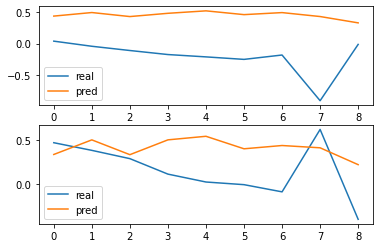

In [10]:
lista = np.random.randint(0,525,2)

fig, ax = plt.subplots(2,1)
j = 0
for i in lista:
    ax[j].plot(X[i], label = 'real')
    ax[j].plot(decoded_valores[i], label = 'pred')
    ax[j].legend()
    j += 1

In [11]:
encoded_valores

array([[0.38142726, 0.95575213, 0.        ],
       [0.05663872, 1.0897505 , 0.        ],
       [0.6873607 , 0.8167654 , 0.        ],
       ...,
       [0.14463809, 0.6404337 , 0.        ],
       [1.7938533 , 0.        , 0.        ],
       [1.7707179 , 0.        , 0.        ]], dtype=float32)

In [12]:
import sklearn.cluster as clust 
km = clust.KMeans()
km.fit(encoded_valores)
km.labels_

array([3, 1, 3, 3, 1, 1, 7, 1, 3, 7, 1, 1, 1, 1, 1, 4, 7, 2, 2, 2, 3, 6,
       6, 6, 2, 2, 7, 2, 2, 2, 2, 3, 2, 2, 2, 6, 4, 2, 7, 6, 6, 3, 2, 2,
       2, 7, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 6, 3, 1, 2, 4, 2, 1, 3,
       6, 2, 7, 2, 6, 2, 4, 6, 2, 2, 2, 6, 2, 2, 2, 2, 6, 2, 2, 6, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 7, 2, 6, 6, 6, 2, 6, 2, 7,
       2, 2, 7, 6, 1, 2, 2, 3, 4, 2, 2, 7, 2, 2, 6, 2, 3, 6, 2, 2, 2, 2,
       2, 2, 2, 2, 6, 2, 1, 6, 2, 6, 2, 4, 2, 2, 3, 6, 2, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 2, 1, 3, 1, 1, 1,
       1, 4, 6, 1, 1, 1, 1, 4, 0, 1, 1, 2, 1, 1, 7, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7,
       5, 1, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 6,
       0, 6, 2, 2, 6, 4, 0, 2, 6, 6, 2, 6, 6, 2, 5, 5, 3, 5, 5, 5, 5, 7,
       1, 5, 5, 7, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 7, 3, 7,
       3, 4, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 6, 6, 6,

In [13]:
import sklearn.metrics as met 
met.silhouette_score(encoded_valores, km.labels_)

0.5013621

In [14]:
met.silhouette_score(X, km.labels_)

0.14442391969979673

In [15]:
from lq import *
lqcovid = lq_peri(covid2[['clasificac','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.8596938775510204

In [16]:
aglo = clust.AgglomerativeClustering(n_clusters = 30)
aglo.fit(encoded_valores)
met.silhouette_score(encoded_valores, aglo.labels_)

0.4753133

In [17]:
1-lqcovid.calcular_indice_debil(aglo.labels_)

0.8845648604269294

<AxesSubplot:>

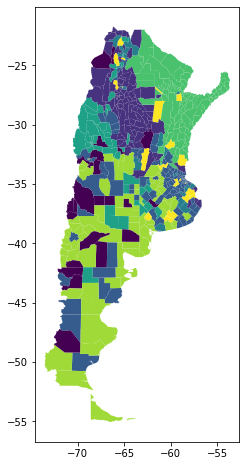

In [18]:
covid_acum_geo = covid_ult_mes.copy()
covid_acum_geo['geometry'] = geo
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8))

<AxesSubplot:>

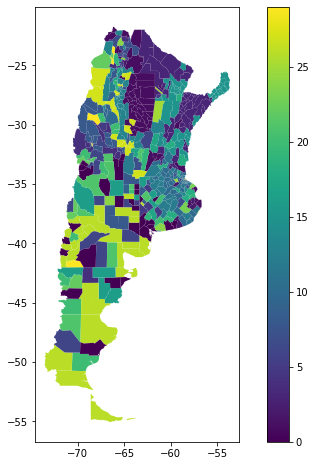

In [19]:
gpd.GeoDataFrame(covid_acum_geo).plot(aglo.labels_, figsize = (10,8), legend = True)

In [20]:
variable = (covid_acum.fallecido/(covid.loc[pd.IndexSlice[:,Mes:],:].personas/10000)).fillna(0)
X = norm_l2.fit_transform(pipe_coord.fit_transform(variable))
X.shape

(525, 19)

In [21]:
entrada = layers.Input(shape = (19,))
encoder = layers.Dense(5, activation = "relu")(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(19, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "mse")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 100       
_________________________________________________________________
dense_3 (Dense)              (None, 19)                114       
Total params: 214
Trainable params: 214
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 292us/sample - loss: 0.3181
Epoch 2/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3173
Epoch 3/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3166
Epoch 4/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3158
Epoch 5/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3151
Epoch 6/50
525/525 [==============================] - 0s 18us/sample - loss: 0.3143
Epoch 7/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3136
Epoch 8/50
525/525 [==============================] - 0s 17us/sample - loss: 0.3129
Epoch 9/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3121
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3114
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3107
Epoch 12/50
525/525 [==============================]

In [23]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

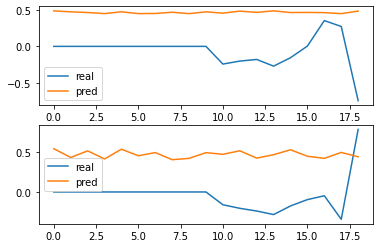

In [24]:
lista = np.random.randint(0,525,2)

fig, ax = plt.subplots(2,1)
j = 0
for i in lista:
    ax[j].plot(X[i], label = 'real')
    ax[j].plot(decoded_valores[i], label = 'pred')
    ax[j].legend()
    j += 1

In [25]:
km.fit(encoded_valores)
met.silhouette_score(encoded_valores, km.labels_)

0.4903475

In [26]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.5178571428571428

In [27]:
met.silhouette_score(X, km.labels_)

0.3037624323680275

In [28]:
from tensorflow.keras import regularizers
peri = procesos.peri_columna()
X = peri.fit_transform(variable)
X = norm_l2.fit_transform(X)
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(17, activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 17)                102       
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [29]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 352us/sample - loss: 1.4912
Epoch 2/50
525/525 [==============================] - 0s 21us/sample - loss: 1.3541
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: 1.2181
Epoch 4/50
525/525 [==============================] - 0s 19us/sample - loss: 1.0845
Epoch 5/50
525/525 [==============================] - 0s 21us/sample - loss: 0.9573
Epoch 6/50
525/525 [==============================] - 0s 21us/sample - loss: 0.8344
Epoch 7/50
525/525 [==============================] - 0s 19us/sample - loss: 0.7165
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 0.6035
Epoch 9/50
525/525 [==============================] - 0s 19us/sample - loss: 0.4943
Epoch 10/50
525/525 [==============================] - 0s 19us/sample - loss: 0.3930
Epoch 11/50
525/525 [==============================] - 0s 21us/sample - loss: 0.2995
Epoch 12/50
525/525 [==============================]

In [30]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

In [31]:
cent = procesos.agrega_centroides(centroides)
encoded_valores = cent.fit_transform(encoded_valores)
encoded_valores = norm_l1.fit_transform(encoded_valores)

In [32]:
km.fit(encoded_valores)
met.silhouette_score(encoded_valores, km.labels_)

0.40748928066261114

In [33]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(km.labels_)

0.4611344537815125

<AxesSubplot:>

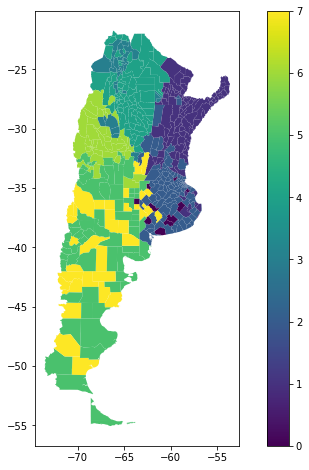

In [34]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [35]:
aglo = clust.AgglomerativeClustering(n_clusters = 15)
aglo.fit(encoded_valores)

AgglomerativeClustering(n_clusters=15)

In [36]:
met.silhouette_score(encoded_valores, aglo.labels_)

0.3428860953065749

In [37]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(aglo.labels_)

0.4638655462184874

<AxesSubplot:>

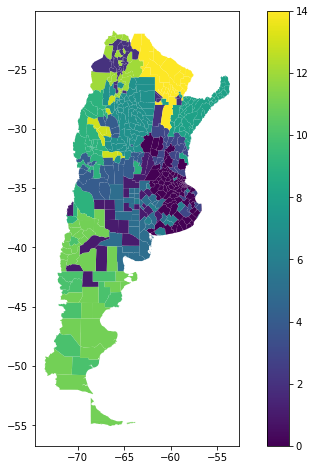

In [38]:
gpd.GeoDataFrame(covid_acum_geo).plot(aglo.labels_, figsize = (10,8), legend = True)

In [41]:
db = clust.DBSCAN(eps = 0.3, min_samples = 10).fit(encoded_valores)

In [42]:
met.silhouette_score(encoded_valores, db.labels_)

0.5022670125851729

In [43]:
lqcovid = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid.calcular_indice_debil(db.labels_)

0.47058823529411764

<AxesSubplot:>

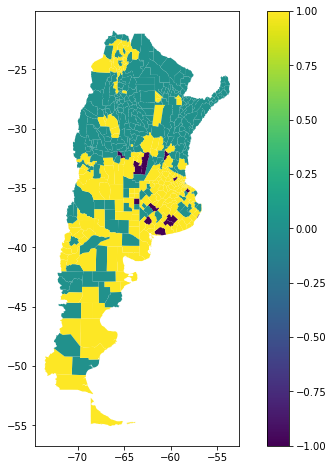

In [44]:
gpd.GeoDataFrame(covid_acum_geo).plot(db.labels_, figsize = (10,8), legend = True)

## positivos y confirmados

In [81]:
datos = covid_acum.apply(lambda x: x/covid_acum.personas*10000)[['clasificac','fallecido']]
X = pipe.fit_transform(datos)
X.shape

(525, 36)

In [82]:
geom = X[:,-2:]
temp = X[:,:-2]
temp

array([[ 0.01019815,  0.02255377,  0.28484866, ..., -0.00269762,
        -0.00582242, -0.00754496],
       [ 0.07559766,  0.02291428,  0.05604072, ..., -0.02123058,
        -0.02908875, -0.03628396],
       [ 0.0487999 ,  0.02010549,  0.06549028, ...,  0.00161269,
        -0.00326928, -0.0066822 ],
       ...,
       [ 0.02392621,  0.00505088, -0.00231598, ..., -0.00580062,
        -0.01395431, -0.01703127],
       [ 0.0056541 ,  0.00464607,  0.00065598, ...,  0.02104742,
         0.01789335,  0.01745624],
       [ 0.1432737 ,  0.09345447,  0.05301385, ...,  0.01337681,
         0.01034025,  0.00910384]])

In [83]:
X = temp
entrada = layers.Input(shape = (X.shape[1],))
encoder = layers.Dense(5, activation = "relu", kernel_regularizer = regularizers.l1(0.1))(entrada)
#encoder = layers.Dense(5, activation = "relu")(encoder)
decoder = layers.Dense(X.shape[1], activation = "sigmoid")(encoder)

autoencoder = Model(inputs = entrada, outputs = decoder)
autoencoder.compile(optimizer = "sgd", loss = "categorical_crossentropy")
enco = Model(inputs = entrada, outputs = encoder)

autoencoder.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 175       
_________________________________________________________________
dense_9 (Dense)              (None, 34)                204       
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [84]:
autoencoder.fit(X, X, epochs = 50)

Train on 525 samples
Epoch 1/50
525/525 [==============================] - 0s 356us/sample - loss: 2.6037
Epoch 2/50
525/525 [==============================] - 0s 21us/sample - loss: 2.3265
Epoch 3/50
525/525 [==============================] - 0s 21us/sample - loss: 2.0642
Epoch 4/50
525/525 [==============================] - 0s 21us/sample - loss: 1.8187
Epoch 5/50
525/525 [==============================] - 0s 21us/sample - loss: 1.5900
Epoch 6/50
525/525 [==============================] - 0s 21us/sample - loss: 1.3732
Epoch 7/50
525/525 [==============================] - 0s 21us/sample - loss: 1.1651
Epoch 8/50
525/525 [==============================] - 0s 19us/sample - loss: 0.9714
Epoch 9/50
525/525 [==============================] - 0s 22us/sample - loss: 0.7949
Epoch 10/50
525/525 [==============================] - 0s 21us/sample - loss: 0.6340
Epoch 11/50
525/525 [==============================] - 0s 19us/sample - loss: 0.4882
Epoch 12/50
525/525 [==============================]

In [85]:
encoded_input = layers.Input(shape = (5,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_valores = enco.predict(X)
decoded_valores = decoder.predict(encoded_valores)

In [86]:
X = np.c_[encoded_valores,geom]
km.fit(X)

KMeans()

In [87]:
met.silhouette_score(X, km.labels_)

0.42230370433600994

In [88]:
lqcovid_f = lq_peri(covid_acum[['fallecido','personas']])
1-lqcovid_f.calcular_indice_debil(km.labels_)

0.5640756302521008

In [89]:
lqcovid_p = lq_peri(covid_acum[['clasificac','personas']])
1-lqcovid_p.calcular_indice_debil(km.labels_)

0.7636554621848739

In [90]:
aglo.fit(X)
met.silhouette_score(X, aglo.labels_)

0.3801502559552681

In [91]:
lqcovid_f.calcular_indice_debil(aglo.labels_)

0.49411764705882344

In [92]:
lqcovid_p.calcular_indice_debil(aglo.labels_)

0.20784313725490194

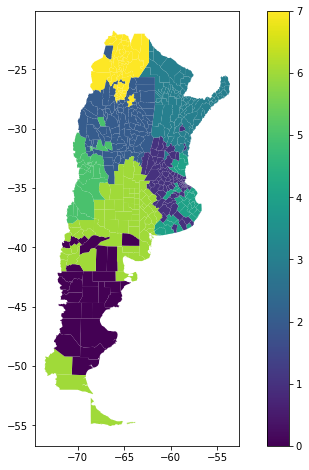

In [93]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True).figure.savefig('Resultados/Imagenes/km_autoencoders.jpg')

In [119]:
lq(datos, 'fallecido','clasificac')

[link   mes    
 2001   2020-03    0.142857
        2020-04    0.131868
        2020-05    0.022946
        2020-06    0.025365
        2020-07    0.028564
                     ...   
 94014  2021-03    0.016169
        2021-04    0.015166
        2021-05    0.014618
        2021-06    0.014426
        2021-07    0.014128
 Length: 8925, dtype: float64,
 0.026326726067011915,
 link   mes    
 2001   2020-03    5.426316
        2020-04    5.008907
        2020-05    0.871569
        2020-06    0.963474
        2020-07    1.084979
                     ...   
 94014  2021-03    0.614159
        2021-04    0.576073
        2021-05    0.555245
        2021-06    0.547975
        2021-07    0.536634
 Length: 8925, dtype: float64]

<AxesSubplot:>

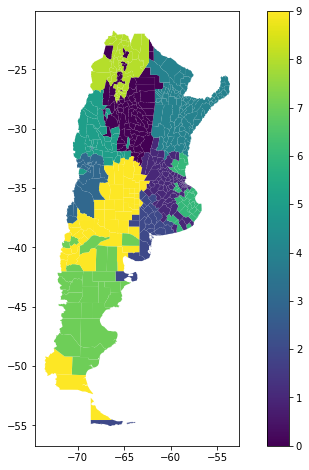

In [111]:
km10 = clust.KMeans(10)
km10.fit(X)
gpd.GeoDataFrame(covid_acum_geo).plot(km10.labels_, figsize = (10,8), legend = True)

In [112]:
met.silhouette_score(X, km10.labels_)

0.43207436618476186

In [113]:
1-lqcovid_f.calcular_indice_debil(km10.labels_)

0.5405228758169934

In [114]:
1-lqcovid_p.calcular_indice_debil(km10.labels_)

0.7705882352941177

In [66]:
XX = pipe.fit_transform(datos)
km.fit(np.c_[temp,geom])

KMeans()

<AxesSubplot:>

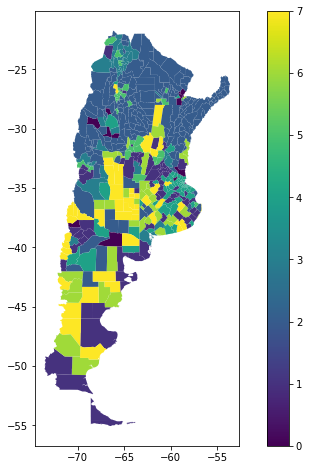

In [67]:
gpd.GeoDataFrame(covid_acum_geo).plot(km.labels_, figsize = (10,8), legend = True)

In [68]:
met.silhouette_score(temp, km.labels_)

0.28715338989988015

In [69]:
lqcovid_f.calcular_indice_debil(km.labels_)

0.3918067226890756

In [70]:
lqcovid_p.calcular_indice_debil(km.labels_)

0.22163865546218486

In [77]:
covid_acum.loc[2001]

,clasificac,fallecido,personas
mes,,,
2020-03,14.0,2.0,205886
2020-04,91.0,12.0,205886
2020-05,1874.0,43.0,205886
2020-06,2602.0,66.0,205886
2020-07,3816.0,109.0,205886
2020-08,5187.0,133.0,205886
2020-09,6061.0,163.0,205886
2020-10,6669.0,181.0,205886
2020-11,7079.0,189.0,205886


In [79]:
temp

array([[ 0.01019815,  0.02255377,  0.28484866, ..., -0.00269762,
        -0.00582242, -0.00754496],
       [ 0.07559766,  0.02291428,  0.05604072, ..., -0.02123058,
        -0.02908875, -0.03628396],
       [ 0.0487999 ,  0.02010549,  0.06549028, ...,  0.00161269,
        -0.00326928, -0.0066822 ],
       ...,
       [ 0.02392621,  0.00505088, -0.00231598, ..., -0.00580062,
        -0.01395431, -0.01703127],
       [ 0.0056541 ,  0.00464607,  0.00065598, ...,  0.02104742,
         0.01789335,  0.01745624],
       [ 0.1432737 ,  0.09345447,  0.05301385, ...,  0.01337681,
         0.01034025,  0.00910384]])